# Analysis of results in Laplace Channel

In [44]:
import numpy as np
import pickle
from itertools import cycle, product
import dill

import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [45]:
# The one who steals the data
def robinhood(fig, filename, col_dtype=[float, float], col_fmt=None):
    assert (len(fig.axes) < 2), "More than one axis not supported"
    ax = fig.axes[0]
    
    header = []
    fmt = []
    
    # Don't modify the argument here, it will get updated for all the following calls
    if not col_fmt:
        _col_fmt = [ "%d" if d == int else "%.5f" for d in col_dtype ]
    else:
        _col_fmt = col_fmt.copy()
    
    n_lines = len(ax.lines)
    x_data = ax.lines[0].get_xdata()
    
    data = np.zeros((x_data.shape[0], 2 * n_lines))
    
    for(i, line) in enumerate(ax.lines):
        data[:, 2*i] = line.get_xdata()
        data[:, 2*i+1] = line.get_ydata()
        
        header += ["x_" + line.get_label(), "y_" + line.get_label()]
        fmt += _col_fmt
            
    if filename is not None:
        with open(filename, 'w') as f:
            f.write(",".join(header) + "\n")
            np.savetxt(f, data, delimiter=",", fmt=",".join(fmt))

#### System Configuration

In [46]:
blkSize     = 4
chDim       = 2

# Input
inVecDim   = 2 ** blkSize  # 1-hot vector length for block
encDim = 2*chDim

SNR_range_dB = np.arange( 0.0, 11.0, 1.0 )

To store the results

In [47]:
results = {}

## Traditional Systems

### QAM

Generate QPSK Map

In [48]:
if blkSize == 2*chDim:
    qam_map = np.array(list(map(list, product([-1, +1], repeat=blkSize))))
elif blkSize==4 and chDim==1:
    qam_map = np.array([
        [ -3.0, -3.0 ],
        [ -3.0, -1.0 ],
        [ -3.0, 1.0 ],
        [ -3.0, 3.0 ],
        [ -1.0, -3.0 ],
        [ -1.0, -1.0 ],
        [ -1.0, 1.0 ],
        [ -1.0, 3.0 ],
        [ 1.0, -3.0 ],
        [ 1.0, -1.0 ],
        [ 1.0, 1.0 ],
        [ 1.0, 3.0 ],
        [ 3.0, -3.0 ],
        [ 3.0, -1.0 ],
        [ 3.0, 1.0 ],
        [ 3.0, 3.0 ]
    ])
else:
    raise NotImplementedError("Not implemented (blkSize={},chDim={})".format(blkSize,chDim))
qam_sym_pow = np.mean(np.sum(qam_map*qam_map,axis=1))
print( "QAM Avg. Tx Power:", qam_sym_pow )

noisePower = qam_sym_pow * 10.0**(-SNR_range_dB/10.0)
n0_per_comp = noisePower/(2*chDim)

QAM Avg. Tx Power: 4.0


Test BLER for SNR Range

In [49]:
err = []
for n0 in n0_per_comp:
  thisErr = 0
  thisCount = 0
  while thisErr < 1000:
    txSym = np.random.randint(inVecDim, size=1000)
    txTest = qam_map[txSym]
    rxTest = txTest + np.random.laplace(scale=np.sqrt(n0/2), size=txTest.shape)
    rxDecode = cdist(rxTest, qam_map)
    rxSym = np.argmin(rxDecode,axis=1)
    thisErr += np.sum(rxSym!=txSym)
    thisCount += 1000
  err.append(thisErr/thisCount)
results["QAM"] = np.array(err)

### Agrell

In [50]:
agrell_map = []
if blkSize==2 and chDim==1:
    agrell_map = np.array([
        [ -1.0, -1.0 ],
        [ -1.0, 1.0 ],
        [ 1.0, -1.0 ],
        [ 1.0, 1.0 ]
    ])
#     agrell_map = np.array([
#         [ +1.0,  0.0 ],
#         [  0.0, +1.0 ],
#         [ -1.0,  0.0 ],
#         [  0.0, -1.0 ]
#     ])
elif blkSize==4 and chDim==1:
    agrell_map = np.array([
        [ -7.0, -3.4641016151377544 ],
        [ -7.0, 3.4641016151377544 ],
        [ -5.0, 0. ],
        [ -3.0, -3.4641016151377544 ],
        [ -3.0, 3.4641016151377544 ],
        [ -1.0, -6.928203230275509 ],
        [ -1.0, 0. ],
        [ -1.0, 6.928203230275509 ],
        [ 1.0, -3.4641016151377544 ],
        [ 1.0, 3.4641016151377544 ],
        [ 3.0, -6.928203230275509 ],
        [ 3.0, 0. ],
        [ 3.0, 6.928203230275509 ],
        [ 5.0, -3.4641016151377544 ],
        [ 5.0, 3.4641016151377544 ],
        [ 7.0, 0. ]
    ])
elif blkSize==4 and chDim==2:
    agrell_map = np.array([
        [2.148934030042627, 0.0, 0.0, 0.0],
        [0.7347204676695321, 1.4142135623730951, 0.0, 0.0],
        [0.7347204676695321, -1.4142135623730951, 0.0, 0.0],
        [0.7347204676695321, 0.0, 1.4142135623730951, 0.0],
        [0.7347204676695321, 0.0, -1.4142135623730951, 0.0],
        [0.7347204676695321, 0.0, 0.0, 1.4142135623730951],
        [0.7347204676695321, 0.0, 0.0, -1.4142135623730951],
        [-0.6174729817844246, 1.0, 1.0, 1.0],
        [-0.6174729817844246, 1.0, 1.0, -1.0],
        [-0.6174729817844246, 1.0, -1.0, 1.0],
        [-0.6174729817844246, 1.0, -1.0, -1.0],
        [-0.6174729817844246, -1.0, 1.0, 1.0],
        [-0.6174729817844246, -1.0, 1.0, -1.0],
        [-0.6174729817844246, -1.0, -1.0, 1.0],
        [-0.6174729817844246, -1.0, -1.0, -1.0],
        [-1.6174729817844242, 0.0, 0.0, 0.0]
    ])
elif blkSize==8 and chDim==4:
    agrell_map = np.array([
        [ -256.0, -256.0, 8.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ -256.0, 0.0, -248.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ -256.0, 0.0, 8.0, -264.0, -8.0, 14.0, 11.0, -11.0 ],
        [ -256.0, 0.0, 8.0, -8.0, -264.0, 14.0, 11.0, -11.0 ],
        [ -256.0, 0.0, 8.0, -8.0, -8.0, -242.0, 11.0, -11.0 ],
        [ -256.0, 0.0, 8.0, -8.0, -8.0, 14.0, -245.0, -11.0 ],
        [ -256.0, 0.0, 8.0, -8.0, -8.0, 14.0, 11.0, -267.0 ],
        [ -256.0, 0.0, 8.0, -8.0, -8.0, 14.0, 11.0, 245.0 ],
        [ -256.0, 0.0, 8.0, -8.0, -8.0, 14.0, 267.0, -11.0 ],
        [ -256.0, 0.0, 8.0, -8.0, -8.0, 270.0, 11.0, -11.0 ],
        [ -256.0, 0.0, 8.0, -8.0, 248.0, 14.0, 11.0, -11.0 ],
        [ -256.0, 0.0, 8.0, 248.0, -8.0, 14.0, 11.0, -11.0 ],
        [ -256.0, 0.0, 264.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ -256.0, 256.0, 8.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ -128.0, -128.0, -120.0, -136.0, -136.0, -114.0, -117.0, -139.0 ],
        [ -128.0, -128.0, -120.0, -136.0, -136.0, -114.0, 139.0, 117.0 ],
        [ -128.0, -128.0, -120.0, -136.0, -136.0, 142.0, -117.0, 117.0 ],
        [ -128.0, -128.0, -120.0, -136.0, -136.0, 142.0, 139.0, -139.0 ],
        [ -128.0, -128.0, -120.0, -136.0, 120.0, -114.0, -117.0, 117.0 ],
        [ -128.0, -128.0, -120.0, -136.0, 120.0, -114.0, 139.0, -139.0 ],
        [ -128.0, -128.0, -120.0, -136.0, 120.0, 142.0, -117.0, -139.0 ],
        [ -128.0, -128.0, -120.0, -136.0, 120.0, 142.0, 139.0, 117.0 ],
        [ -128.0, -128.0, -120.0, 120.0, -136.0, -114.0, -117.0, 117.0 ],
        [ -128.0, -128.0, -120.0, 120.0, -136.0, -114.0, 139.0, -139.0 ],
        [ -128.0, -128.0, -120.0, 120.0, -136.0, 142.0, -117.0, -139.0 ],
        [ -128.0, -128.0, -120.0, 120.0, -136.0, 142.0, 139.0, 117.0 ],
        [ -128.0, -128.0, -120.0, 120.0, 120.0, -370.0, -117.0, 117.0 ],
        [ -128.0, -128.0, -120.0, 120.0, 120.0, -114.0, -373.0, 117.0 ],
        [ -128.0, -128.0, -120.0, 120.0, 120.0, -114.0, -117.0, -139.0 ],
        [ -128.0, -128.0, -120.0, 120.0, 120.0, -114.0, -117.0, 373.0 ],
        [ -128.0, -128.0, -120.0, 120.0, 120.0, -114.0, 139.0, 117.0 ],
        [ -128.0, -128.0, -120.0, 120.0, 120.0, 142.0, -117.0, 117.0 ],
        [ -128.0, -128.0, -120.0, 120.0, 120.0, 142.0, 139.0, -139.0 ],
        [ -128.0, -128.0, 136.0, -136.0, -136.0, -114.0, -117.0, 117.0 ],
        [ -128.0, -128.0, 136.0, -136.0, -136.0, -114.0, 139.0, -139.0 ],
        [ -128.0, -128.0, 136.0, -136.0, -136.0, 142.0, -117.0, -139.0 ],
        [ -128.0, -128.0, 136.0, -136.0, -136.0, 142.0, 139.0, 117.0 ],
        [ -128.0, -128.0, 136.0, -136.0, 120.0, -114.0, -117.0, -139.0 ],
        [ -128.0, -128.0, 136.0, -136.0, 120.0, -114.0, 139.0, 117.0 ],
        [ -128.0, -128.0, 136.0, -136.0, 120.0, 142.0, -117.0, 117.0 ],
        [ -128.0, -128.0, 136.0, -136.0, 120.0, 142.0, 139.0, -139.0 ],
        [ -128.0, -128.0, 136.0, 120.0, -136.0, -114.0, -117.0, -139.0 ],
        [ -128.0, -128.0, 136.0, 120.0, -136.0, -114.0, 139.0, 117.0 ],
        [ -128.0, -128.0, 136.0, 120.0, -136.0, 142.0, -117.0, 117.0 ],
        [ -128.0, -128.0, 136.0, 120.0, -136.0, 142.0, 139.0, -139.0 ],
        [ -128.0, -128.0, 136.0, 120.0, 120.0, -114.0, -117.0, 117.0 ],
        [ -128.0, -128.0, 136.0, 120.0, 120.0, -114.0, 139.0, -139.0 ],
        [ -128.0, -128.0, 136.0, 120.0, 120.0, 142.0, -117.0, -139.0 ],
        [ -128.0, -128.0, 136.0, 120.0, 120.0, 142.0, 139.0, 117.0 ],
        [ -128.0, 128.0, -120.0, -136.0, -136.0, -114.0, -117.0, 117.0 ],
        [ -128.0, 128.0, -120.0, -136.0, -136.0, -114.0, 139.0, -139.0 ],
        [ -128.0, 128.0, -120.0, -136.0, -136.0, 142.0, -117.0, -139.0 ],
        [ -128.0, 128.0, -120.0, -136.0, -136.0, 142.0, 139.0, 117.0 ],
        [ -128.0, 128.0, -120.0, -136.0, 120.0, -114.0, -117.0, -139.0 ],
        [ -128.0, 128.0, -120.0, -136.0, 120.0, -114.0, 139.0, 117.0 ],
        [ -128.0, 128.0, -120.0, -136.0, 120.0, 142.0, -117.0, 117.0 ],
        [ -128.0, 128.0, -120.0, -136.0, 120.0, 142.0, 139.0, -139.0 ],
        [ -128.0, 128.0, -120.0, 120.0, -136.0, -114.0, -117.0, -139.0 ],
        [ -128.0, 128.0, -120.0, 120.0, -136.0, -114.0, 139.0, 117.0 ],
        [ -128.0, 128.0, -120.0, 120.0, -136.0, 142.0, -117.0, 117.0 ],
        [ -128.0, 128.0, -120.0, 120.0, -136.0, 142.0, 139.0, -139.0 ],
        [ -128.0, 128.0, -120.0, 120.0, 120.0, -114.0, -117.0, 117.0 ],
        [ -128.0, 128.0, -120.0, 120.0, 120.0, -114.0, 139.0, -139.0 ],
        [ -128.0, 128.0, -120.0, 120.0, 120.0, 142.0, -117.0, -139.0 ],
        [ -128.0, 128.0, -120.0, 120.0, 120.0, 142.0, 139.0, 117.0 ],
        [ -128.0, 128.0, 136.0, -136.0, -136.0, -114.0, -117.0, -139.0 ],
        [ -128.0, 128.0, 136.0, -136.0, -136.0, -114.0, 139.0, 117.0 ],
        [ -128.0, 128.0, 136.0, -136.0, -136.0, 142.0, -117.0, 117.0 ],
        [ -128.0, 128.0, 136.0, -136.0, -136.0, 142.0, 139.0, -139.0 ],
        [ -128.0, 128.0, 136.0, -136.0, 120.0, -114.0, -117.0, 117.0 ],
        [ -128.0, 128.0, 136.0, -136.0, 120.0, -114.0, 139.0, -139.0 ],
        [ -128.0, 128.0, 136.0, -136.0, 120.0, 142.0, -117.0, -139.0 ],
        [ -128.0, 128.0, 136.0, -136.0, 120.0, 142.0, 139.0, 117.0 ],
        [ -128.0, 128.0, 136.0, 120.0, -136.0, -114.0, -117.0, 117.0 ],
        [ -128.0, 128.0, 136.0, 120.0, -136.0, -114.0, 139.0, -139.0 ],
        [ -128.0, 128.0, 136.0, 120.0, -136.0, 142.0, -117.0, -139.0 ],
        [ -128.0, 128.0, 136.0, 120.0, -136.0, 142.0, 139.0, 117.0 ],
        [ -128.0, 128.0, 136.0, 120.0, 120.0, -114.0, -117.0, -139.0 ],
        [ -128.0, 128.0, 136.0, 120.0, 120.0, -114.0, 139.0, 117.0 ],
        [ -128.0, 128.0, 136.0, 120.0, 120.0, 142.0, -117.0, 117.0 ],
        [ -128.0, 128.0, 136.0, 120.0, 120.0, 142.0, 139.0, -139.0 ],
        [ 0.0, -256.0, -248.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, -256.0, 8.0, -264.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, -256.0, 8.0, -8.0, -264.0, 14.0, 11.0, -11.0 ],
        [ 0.0, -256.0, 8.0, -8.0, -8.0, -242.0, 11.0, -11.0 ],
        [ 0.0, -256.0, 8.0, -8.0, -8.0, 14.0, -245.0, -11.0 ],
        [ 0.0, -256.0, 8.0, -8.0, -8.0, 14.0, 11.0, -267.0 ],
        [ 0.0, -256.0, 8.0, -8.0, -8.0, 14.0, 11.0, 245.0 ],
        [ 0.0, -256.0, 8.0, -8.0, -8.0, 14.0, 267.0, -11.0 ],
        [ 0.0, -256.0, 8.0, -8.0, -8.0, 270.0, 11.0, -11.0 ],
        [ 0.0, -256.0, 8.0, -8.0, 248.0, 14.0, 11.0, -11.0 ],
        [ 0.0, -256.0, 8.0, 248.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, -256.0, 264.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -264.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -264.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -8.0, -242.0, -245.0, 245.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -8.0, -242.0, 11.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -8.0, 14.0, -245.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -8.0, 14.0, 11.0, -267.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -8.0, 14.0, 11.0, 245.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -8.0, 14.0, 267.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -8.0, 270.0, 11.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -8.0, 248.0, -242.0, -245.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -8.0, 248.0, -242.0, 11.0, 245.0 ],
        [ 0.0, 0.0, -248.0, -8.0, 248.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, -248.0, 248.0, -8.0, -242.0, -245.0, -11.0 ],
        [ 0.0, 0.0, -248.0, 248.0, -8.0, -242.0, 11.0, 245.0 ],
        [ 0.0, 0.0, -248.0, 248.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -264.0, -264.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -264.0, -8.0, -242.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -264.0, -8.0, 14.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -264.0, -8.0, 14.0, 11.0, -267.0 ],
        [ 0.0, 0.0, 8.0, -264.0, -8.0, 14.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -264.0, -8.0, 14.0, 267.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -264.0, -8.0, 270.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -264.0, 248.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -264.0, -242.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -264.0, 14.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -264.0, 14.0, 11.0, -267.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -264.0, 14.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -264.0, 14.0, 267.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -264.0, 270.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, -242.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, -242.0, 11.0, -267.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, -242.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, -242.0, 267.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 14.0, -245.0, -267.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 14.0, -245.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 14.0, 267.0, -267.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 14.0, 267.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 270.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 270.0, 11.0, -267.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 270.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 270.0, 267.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, 248.0, -242.0, -245.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -8.0, 248.0, -242.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, 248.0, 14.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, 248.0, 14.0, 11.0, -267.0 ],
        [ 0.0, 0.0, 8.0, -8.0, 248.0, 14.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -8.0, 248.0, 14.0, 267.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, 248.0, 270.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -264.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -8.0, -242.0, -245.0, 245.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -8.0, -242.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -8.0, 14.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -8.0, 14.0, 11.0, -267.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -8.0, 14.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -8.0, 14.0, 267.0, -11.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -8.0, 270.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, 248.0, 248.0, -242.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 8.0, 248.0, 248.0, -242.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 8.0, 248.0, 248.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 264.0, -264.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 264.0, -8.0, -264.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 264.0, -8.0, -8.0, -242.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 264.0, -8.0, -8.0, 14.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 264.0, -8.0, -8.0, 14.0, 11.0, -267.0 ],
        [ 0.0, 0.0, 264.0, -8.0, -8.0, 14.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 264.0, -8.0, -8.0, 14.0, 267.0, -11.0 ],
        [ 0.0, 0.0, 264.0, -8.0, -8.0, 270.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 264.0, -8.0, 248.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 264.0, 248.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 256.0, -248.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 256.0, 8.0, -264.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 256.0, 8.0, -8.0, -264.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 256.0, 8.0, -8.0, -8.0, -242.0, 11.0, -11.0 ],
        [ 0.0, 256.0, 8.0, -8.0, -8.0, 14.0, -245.0, -11.0 ],
        [ 0.0, 256.0, 8.0, -8.0, -8.0, 14.0, 11.0, -267.0 ],
        [ 0.0, 256.0, 8.0, -8.0, -8.0, 14.0, 11.0, 245.0 ],
        [ 0.0, 256.0, 8.0, -8.0, -8.0, 14.0, 267.0, -11.0 ],
        [ 0.0, 256.0, 8.0, -8.0, -8.0, 270.0, 11.0, -11.0 ],
        [ 0.0, 256.0, 8.0, -8.0, 248.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 256.0, 8.0, 248.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 256.0, 264.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 128.0, -128.0, -120.0, -136.0, -136.0, -114.0, -117.0, 117.0 ],
        [ 128.0, -128.0, -120.0, -136.0, -136.0, -114.0, 139.0, -139.0 ],
        [ 128.0, -128.0, -120.0, -136.0, -136.0, 142.0, -117.0, -139.0 ],
        [ 128.0, -128.0, -120.0, -136.0, -136.0, 142.0, 139.0, 117.0 ],
        [ 128.0, -128.0, -120.0, -136.0, 120.0, -114.0, -117.0, -139.0 ],
        [ 128.0, -128.0, -120.0, -136.0, 120.0, -114.0, 139.0, 117.0 ],
        [ 128.0, -128.0, -120.0, -136.0, 120.0, 142.0, -117.0, 117.0 ],
        [ 128.0, -128.0, -120.0, -136.0, 120.0, 142.0, 139.0, -139.0 ],
        [ 128.0, -128.0, -120.0, 120.0, -136.0, -114.0, -117.0, -139.0 ],
        [ 128.0, -128.0, -120.0, 120.0, -136.0, -114.0, 139.0, 117.0 ],
        [ 128.0, -128.0, -120.0, 120.0, -136.0, 142.0, -117.0, 117.0 ],
        [ 128.0, -128.0, -120.0, 120.0, -136.0, 142.0, 139.0, -139.0 ],
        [ 128.0, -128.0, -120.0, 120.0, 120.0, -114.0, -117.0, 117.0 ],
        [ 128.0, -128.0, -120.0, 120.0, 120.0, -114.0, 139.0, -139.0 ],
        [ 128.0, -128.0, -120.0, 120.0, 120.0, 142.0, -117.0, -139.0 ],
        [ 128.0, -128.0, -120.0, 120.0, 120.0, 142.0, 139.0, 117.0 ],
        [ 128.0, -128.0, 136.0, -136.0, -136.0, -114.0, -117.0, -139.0 ],
        [ 128.0, -128.0, 136.0, -136.0, -136.0, -114.0, 139.0, 117.0 ],
        [ 128.0, -128.0, 136.0, -136.0, -136.0, 142.0, -117.0, 117.0 ],
        [ 128.0, -128.0, 136.0, -136.0, -136.0, 142.0, 139.0, -139.0 ],
        [ 128.0, -128.0, 136.0, -136.0, 120.0, -114.0, -117.0, 117.0 ],
        [ 128.0, -128.0, 136.0, -136.0, 120.0, -114.0, 139.0, -139.0 ],
        [ 128.0, -128.0, 136.0, -136.0, 120.0, 142.0, -117.0, -139.0 ],
        [ 128.0, -128.0, 136.0, -136.0, 120.0, 142.0, 139.0, 117.0 ],
        [ 128.0, -128.0, 136.0, 120.0, -136.0, -114.0, -117.0, 117.0 ],
        [ 128.0, -128.0, 136.0, 120.0, -136.0, -114.0, 139.0, -139.0 ],
        [ 128.0, -128.0, 136.0, 120.0, -136.0, 142.0, -117.0, -139.0 ],
        [ 128.0, -128.0, 136.0, 120.0, -136.0, 142.0, 139.0, 117.0 ],
        [ 128.0, -128.0, 136.0, 120.0, 120.0, -114.0, -117.0, -139.0 ],
        [ 128.0, -128.0, 136.0, 120.0, 120.0, -114.0, 139.0, 117.0 ],
        [ 128.0, -128.0, 136.0, 120.0, 120.0, 142.0, -117.0, 117.0 ],
        [ 128.0, -128.0, 136.0, 120.0, 120.0, 142.0, 139.0, -139.0 ],
        [ 128.0, 128.0, -120.0, -136.0, -136.0, -114.0, -117.0, -139.0 ],
        [ 128.0, 128.0, -120.0, -136.0, -136.0, -114.0, 139.0, 117.0 ],
        [ 128.0, 128.0, -120.0, -136.0, -136.0, 142.0, -117.0, 117.0 ],
        [ 128.0, 128.0, -120.0, -136.0, -136.0, 142.0, 139.0, -139.0 ],
        [ 128.0, 128.0, -120.0, -136.0, 120.0, -114.0, -117.0, 117.0 ],
        [ 128.0, 128.0, -120.0, -136.0, 120.0, -114.0, 139.0, -139.0 ],
        [ 128.0, 128.0, -120.0, -136.0, 120.0, 142.0, -117.0, -139.0 ],
        [ 128.0, 128.0, -120.0, -136.0, 120.0, 142.0, 139.0, 117.0 ],
        [ 128.0, 128.0, -120.0, 120.0, -136.0, -114.0, -117.0, 117.0 ],
        [ 128.0, 128.0, -120.0, 120.0, -136.0, -114.0, 139.0, -139.0 ],
        [ 128.0, 128.0, -120.0, 120.0, -136.0, 142.0, -117.0, -139.0 ],
        [ 128.0, 128.0, -120.0, 120.0, -136.0, 142.0, 139.0, 117.0 ],
        [ 128.0, 128.0, -120.0, 120.0, 120.0, -370.0, -117.0, 117.0 ],
        [ 128.0, 128.0, -120.0, 120.0, 120.0, -114.0, -373.0, 117.0 ],
        [ 128.0, 128.0, -120.0, 120.0, 120.0, -114.0, -117.0, -139.0 ],
        [ 128.0, 128.0, -120.0, 120.0, 120.0, -114.0, -117.0, 373.0 ],
        [ 128.0, 128.0, -120.0, 120.0, 120.0, -114.0, 139.0, 117.0 ],
        [ 128.0, 128.0, -120.0, 120.0, 120.0, 142.0, -117.0, 117.0 ],
        [ 128.0, 128.0, -120.0, 120.0, 120.0, 142.0, 139.0, -139.0 ],
        [ 128.0, 128.0, 136.0, -136.0, -136.0, -114.0, -117.0, 117.0 ],
        [ 128.0, 128.0, 136.0, -136.0, -136.0, -114.0, 139.0, -139.0 ],
        [ 128.0, 128.0, 136.0, -136.0, -136.0, 142.0, -117.0, -139.0 ],
        [ 128.0, 128.0, 136.0, -136.0, -136.0, 142.0, 139.0, 117.0 ],
        [ 128.0, 128.0, 136.0, -136.0, 120.0, -114.0, -117.0, -139.0 ],
        [ 128.0, 128.0, 136.0, -136.0, 120.0, -114.0, 139.0, 117.0 ],
        [ 128.0, 128.0, 136.0, -136.0, 120.0, 142.0, -117.0, 117.0 ],
        [ 128.0, 128.0, 136.0, -136.0, 120.0, 142.0, 139.0, -139.0 ],
        [ 128.0, 128.0, 136.0, 120.0, -136.0, -114.0, -117.0, -139.0 ],
        [ 128.0, 128.0, 136.0, 120.0, -136.0, -114.0, 139.0, 117.0 ],
        [ 128.0, 128.0, 136.0, 120.0, -136.0, 142.0, -117.0, 117.0 ],
        [ 128.0, 128.0, 136.0, 120.0, -136.0, 142.0, 139.0, -139.0 ],
        [ 128.0, 128.0, 136.0, 120.0, 120.0, -114.0, -117.0, 117.0 ],
        [ 128.0, 128.0, 136.0, 120.0, 120.0, -114.0, 139.0, -139.0 ],
        [ 128.0, 128.0, 136.0, 120.0, 120.0, 142.0, -117.0, -139.0 ],
        [ 128.0, 128.0, 136.0, 120.0, 120.0, 142.0, 139.0, 117.0 ],
        [ 256.0, -256.0, 8.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 256.0, 0.0, -248.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 256.0, 0.0, 8.0, -264.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 256.0, 0.0, 8.0, -8.0, -264.0, 14.0, 11.0, -11.0 ],
        [ 256.0, 0.0, 8.0, -8.0, -8.0, -242.0, 11.0, -11.0 ],
        [ 256.0, 0.0, 8.0, -8.0, -8.0, 14.0, -245.0, -11.0 ],
        [ 256.0, 0.0, 8.0, -8.0, -8.0, 14.0, 11.0, -267.0 ],
        [ 256.0, 0.0, 8.0, -8.0, -8.0, 14.0, 11.0, 245.0 ],
        [ 256.0, 0.0, 8.0, -8.0, -8.0, 14.0, 267.0, -11.0 ],
        [ 256.0, 0.0, 8.0, -8.0, -8.0, 270.0, 11.0, -11.0 ],
        [ 256.0, 0.0, 8.0, -8.0, 248.0, 14.0, 11.0, -11.0 ],
        [ 256.0, 0.0, 8.0, 248.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 256.0, 0.0, 264.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 256.0, 256.0, 8.0, -8.0, -8.0, 14.0, 11.0, -11.0 ] ])
else:
    raise NotImplementedError("Not implemented (blkSize={},chDim={})".format(blkSize,chDim))

agrell_sym_pow = np.mean(np.sum(agrell_map*agrell_map,axis=1))
print( "Agrell Avg. Tx Power:", agrell_sym_pow )

noisePower = agrell_sym_pow * 10.0**(-SNR_range_dB/10.0)
n0_per_comp = noisePower/(2*chDim)

Agrell Avg. Tx Power: 3.095200273238941


Test BLER

In [51]:
err = []
for n0 in n0_per_comp:
  thisErr = 0
  thisCount = 0
  while thisErr < 1000:
    txSym = np.random.randint(inVecDim, size=1000)
    txTest = agrell_map[txSym]
    rxTest = txTest + np.random.laplace(scale=np.sqrt(n0/2), size=txTest.shape)
    rxDecode = cdist(rxTest, agrell_map)
    rxSym = np.argmin(rxDecode,axis=1)
    thisErr += np.sum(rxSym!=txSym)
    thisCount += 1000
  err.append(thisErr/thisCount)
results["Agrell"] = np.array(err)

### Plot results

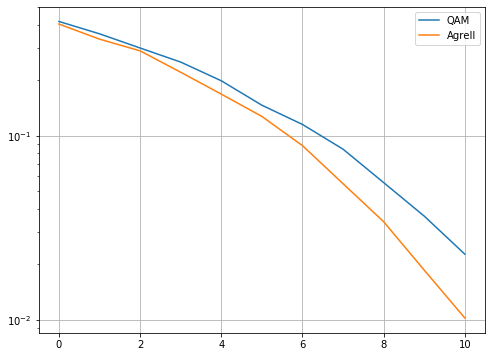

In [52]:
fig = plt.figure(figsize=(8,6))
for (l,v) in results.items():
    plt.semilogy(SNR_range_dB, v, label=l)
plt.legend()
plt.grid()

## Deep Learning Models

List of model summaries to plot

In [59]:
model_summary = {}
if blkSize==4 and chDim==1:
    model_summary = {
        "[1]": "./models/AE/04x01/lap_oshea_64_32_16_010dB_summary.dil",
#         "(19)": "./models/VAE/04x01/lap_awgn_64_32_16_n050_sigma283_summary.dil",
#         "(23)": "./models/VAE/04x01/lap_rbf_64_32_16_n050_sigma283_summary.dil",
        "vae_lap": "./models/VAE/04x01/lap_lap_64_32_16_n050_sigma283_summary.dil", 
    }
elif blkSize==4 and chDim==2:
    model_summary = {
#         "[1]": "./models/AE/04x02/lap_oshea_64_32_16_010dB_summary.dil",
#         "(19)": "./models/VAE/04x02/lap_awgn_64_32_16_n100_sigma283_summary.dil",
#         "(23)": "./models/VAE/04x02/lap_rbf_64_32_16_n100_sigma283_summary.dil",
        "vae_lap": "./models/VAE/04x02/lap_lap_64_32_16_n100_sigma283_summary.dil", 
    }
elif blkSize==2 and chDim==1:
    model_summary = {
        "[1]": "./models/AE/02x01/lap_oshea_64_32_16_010dB_summary.dil",
#         "(19)": "./models/VAE/02x01/lap_awgn_64_32_16_n050_sigma283_summary.dil",
#         "(23)": "./models/VAE/02x01/lap_rbf_64_32_16_n050_sigma283_summary.dil",
        "vae_lap": "./models/VAE/02x01/lap_lap_64_32_16_n050_sigma283_summary.dil", 
    }
else:
    raise NotImplementedError("Not implemented (blkSize={},chDim={})".format(blkSize,chDim))

In [60]:
const_pow = {}
bler_values = {}
bler_mean = {}
bler_std = {}
bler_metrics = {} # To compare which model is better using L2
bler_bestidx = {}
bler_maxidx = {}

Plot the results from all model

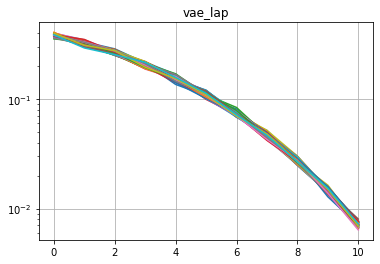

In [61]:
for (model,summary_file) in model_summary.items():
    plt.figure()
    summary_data = {}
    # Load file
    with open(summary_file, "rb") as file:
        summary_data = dill.load(file)
    # Plot each summary
    for (modelid,(sym_pow,bler)) in summary_data.items():
        plt.semilogy(SNR_range_dB, bler)
    plt.title(model)
    plt.grid()
    # Compute metrics
    const_pow[model] = np.array([p for (p,_) in summary_data.values()])
    bler_values[model] = np.array([b for (_,b) in summary_data.values()])
    bler_mean[model] = np.mean(bler_values[model], axis=0)
    bler_std[model] = np.std(bler_values[model], axis=0)
    bler_metrics[model] = np.linalg.norm(bler_values[model], axis=1)
    bler_bestidx[model] = np.argmin(bler_metrics[model])
    bler_maxidx[model] = np.argmax(bler_metrics[model])

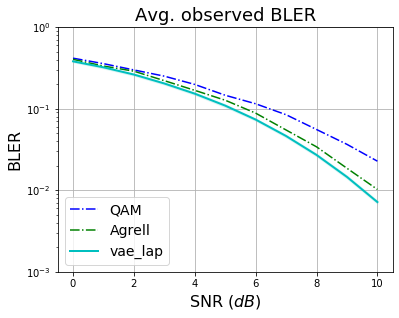

In [63]:
colors = cycle(['b', 'g', 'c', 'r', 'm', 'y'])
fig = plt.figure(figsize=(4*1.5,3*1.5))
for (l,bler) in results.items():
    plt.semilogy(SNR_range_dB, bler, label=l, color=next(colors), linestyle="-.")
for model in model_summary.keys():
    clr = next(colors)
    plt.fill_between(SNR_range_dB, bler_mean[model]+bler_std[model], bler_mean[model]-bler_std[model], alpha=0.1, color=clr)
    plt.semilogy(SNR_range_dB, bler_mean[model], label=model, 
                 color=clr, linewidth=2, linestyle=":" if "Oshea" in model or "[1]" in model else "-")
plt.legend(loc="lower left", prop={'size':14})
plt.grid()
plt.title("Avg. observed BLER", fontdict={'fontsize':18})
plt.xlabel("SNR ($dB$)", fontdict={'fontsize':16})
plt.ylabel("BLER", fontdict={'fontsize':16})
plt.ylim((1e-3,1e0))
# plt.savefig("output_lap_avg_bler_{:02d}x{:02d}.png".format(blkSize,chDim), format='png', bbox_inches='tight')
robinhood(fig, "output_lap_avg_bler_{:02d}x{:02d}.csv".format(blkSize,chDim), col_dtype=[int, float])

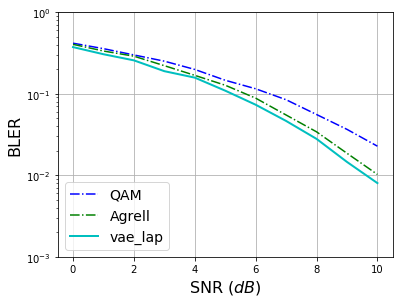

In [64]:
colors = cycle(['b', 'g', 'c', 'r', 'm', 'y'])
fig = plt.figure(figsize=(4*1.5,3*1.5))
# plt.figure(figsize=(8*1.5,6*1.5))
for (l,bler) in results.items():
    plt.semilogy(SNR_range_dB, bler, label=l, color=next(colors), linestyle="-.")
for model in model_summary.keys():
    clr = next(colors)
    plt.semilogy(SNR_range_dB, bler_values[model][bler_bestidx[model]], 
                 label=model, color=clr, linewidth=2,
                 linestyle=":" if "Oshea" in model or "[1]" in model else "-")
plt.legend(loc="lower left", prop={'size':14})
plt.grid()
# plt.title("Best observed BLER of trained models", fontdict={'fontsize':18})
plt.xlabel("SNR ($dB$)", fontdict={'fontsize':16})
plt.ylabel("BLER", fontdict={'fontsize':16})
plt.ylim((1e-3,1e0))
plt.savefig("output_lap_best_bler_{:02d}x{:02d}.pdf".format(blkSize,chDim), format='pdf', bbox_inches='tight')
# plt.savefig("output_awgn_best_bler_{:02d}x{:02d}.eps".format(blkSize,chDim), format='eps', bbox_inches='tight')
# plt.savefig("output_lap_best_bler_{:02d}x{:02d}.png".format(blkSize,chDim), format='png', bbox_inches='tight')
robinhood(fig, "output_lap_best_bler_{:02d}x{:02d}.csv".format(blkSize,chDim), col_dtype=[int, float])

Plot Constellation avg. pow

No handles with labels found to put in legend.


Text(0.5, 0, 'Train SNR (dB)')

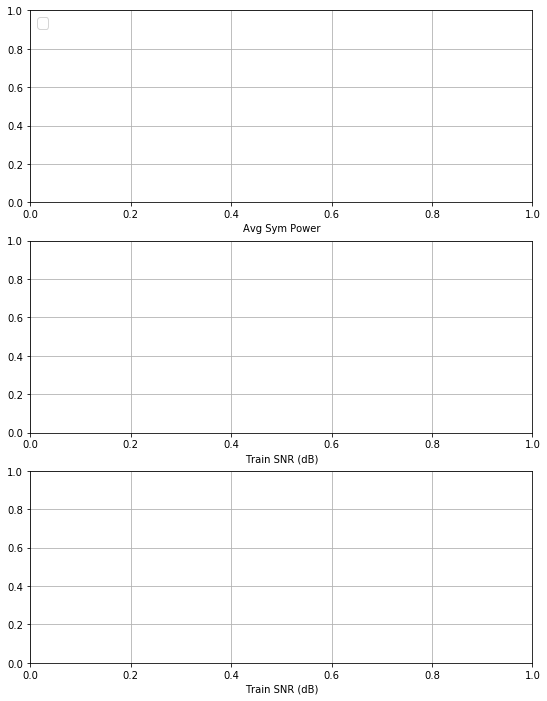

In [65]:
import re
colors = cycle(['b', 'g', 'r', 'c', 'm', 'y'])
fig, ax = plt.subplots(3, figsize=(9,12))
for (model,txpow) in const_pow.items():
    clr = next(colors)
    if "with" in model:  # Other models are trained at constant SNR, so have dB in their label
#         n0 = float(re.findall("\d+\.\d+",model)[0])
        n0 = 0.8
        train_snr = 10.0 * np.log10(txpow/n0)
        ax[0].hist( txpow, label=model, color=clr, bins=10 )
        ax[1].hist( train_snr, label=model, color=clr, bins=10 )
        ax[2].hist( train_snr, label=model, color=clr, bins=100, cumulative=True, histtype="step")
ax[0].legend(loc="upper left", prop={'size':14})

ax[1].set_xlim(left=0)
ax[2].set_xlim(left=0)
for _ax in ax:
    _ax.grid()
ax[0].set_xlabel("Avg Sym Power")
ax[1].set_xlabel("Train SNR (dB)")
ax[2].set_xlabel("Train SNR (dB)")